# SAIL Radiosonde Data Example
### Created by Daniel Hogan - University of Washington
-----------------------------------------
This notebook is designed to investigate recent 2022/2023 winter radiosonde data from SAIL launched from Gothic, CO over a variety of conditions

The `act` package is required for this notebook to download and easily visualize the data. Check out the documentation [here](https://arm-doe.github.io/ACT/index.html).

In [1]:
# Import packages to be used
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import act
import datetime as dt
from soslib import funcs


Please install CDO version 1.9.3 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo
Please install CDO version 1.9.3 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo


# Pull in Data
-------------------------------------

### Use personal access token to pull data
- data is stored temporarily, so it is not saved locally

In [196]:
# Personal access necessary for downloading from the ARM portal, need an account to due so
username = 'dlhogan@uw.edu'
token = '7f1c805e6ae94c21'
radiosonde ='gucsondewnpnM1.b1'
start = '2023-01-01T11:00:00'
end = '2023-01-05T11:00:00' 

In [197]:
# Download SAIL sonde data
sonde_ds = funcs.get_sail_data(username, token, radiosonde, start, end)

[DOWNLOADING] gucsondewnpnM1.b1.20230101.113000.cdf
                             
[DOWNLOADING] gucsondewnpnM1.b1.20230102.112600.cdf
                             
[DOWNLOADING] gucsondewnpnM1.b1.20230101.232600.cdf
                             
[DOWNLOADING] gucsondewnpnM1.b1.20230102.234400.cdf
                             
[DOWNLOADING] gucsondewnpnM1.b1.20230103.113100.cdf
                             
[DOWNLOADING] gucsondewnpnM1.b1.20230103.232800.cdf
                             
[DOWNLOADING] gucsondewnpnM1.b1.20230104.113800.cdf
                             
[DOWNLOADING] gucsondewnpnM1.b1.20230104.232200.cdf
                             


In [216]:
mean_ds = sonde_ds.groupby_bins("pres",50).mean()
mean_ds = mean_ds.isel(pres_bins=slice(None, None, -1))


In [137]:
sonde1_start = dt.datetime.strptime(start,'%Y-%m-%dT%H:%M:%S')
sonde1_end = sonde1_start + dt.timedelta(hours=6)

sonde2_start = sonde1_end + dt.timedelta(hours=6)
sonde2_end = sonde2_start + dt.timedelta(hours=6)

sonde1 = sonde_ds.sel(time=slice(sonde2_start,sonde2_end))
sonde2 = sonde_ds.sel(time=slice(sonde1_start,sonde1_end))

### Add potenetial temperature here for a potential temperature profile

In [225]:
# Don't need to worry about this
kappa = 0.286
sonde_ds = sonde_ds.assign(potential_T = (273.15 + sonde_ds.where(sonde_ds['qc_tdry'] == 0)['tdry']) * (1000 / sonde_ds.where(sonde_ds['qc_tdry'] == 0)['pres'])**kappa - 273.15)
sonde_ds['potential_T'].attrs = {'units':'degC'}

# Plotting 
--------------------------------

### Using ACT plotting functionality, we will plot the radiosonde profiles from these days

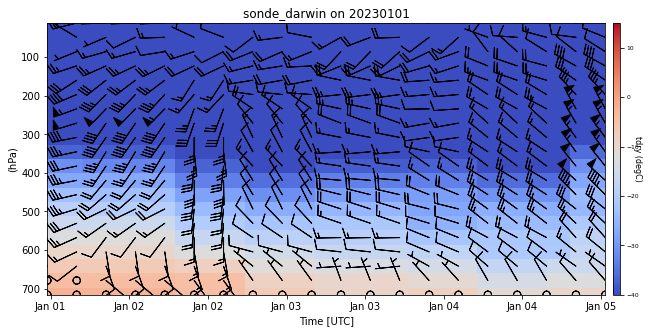

In [223]:
# Don't need to worry about this
BarbDisplay = act.plotting.TimeSeriesDisplay({'sonde_darwin': sonde_ds}, figsize=(10, 5))
BarbDisplay.plot_time_height_xsection_from_1d_data(
    'tdry', 'pres', cmap='coolwarm', vmin=-40, vmax=15, num_time_periods=25
)
BarbDisplay.plot_barbs_from_spd_dir('wspd', 'deg', 'pres', num_barbs_x=20)
plt.show()

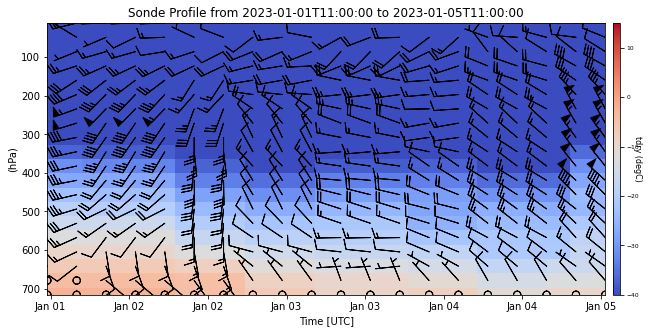

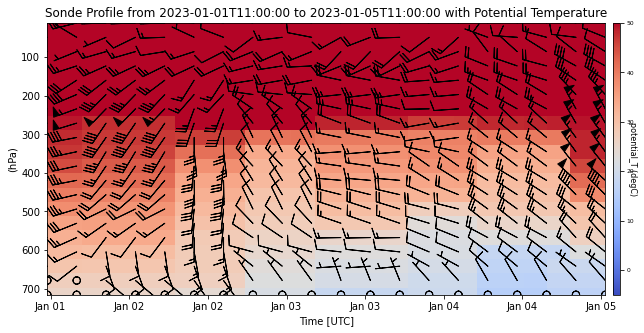

In [226]:
# Don't need to worry about this
BarbDisplay = act.plotting.TimeSeriesDisplay({'sonde_darwin': sonde_ds}, figsize=(10, 5))
BarbDisplay.plot_time_height_xsection_from_1d_data(
    'tdry', 'pres', cmap='coolwarm', vmin=-40, vmax=15, num_time_periods=25
)
BarbDisplay.plot_barbs_from_spd_dir('wspd', 'deg', 'pres', num_barbs_x=20,
                                    set_title=f'Sonde Profile from {start} to {end}')
plt.show()
# Don't need to worry about this
BarbDisplay = act.plotting.TimeSeriesDisplay({'sonde_darwin': sonde_ds}, figsize=(10, 5))
BarbDisplay.plot_time_height_xsection_from_1d_data(
    'potential_T', 'pres', cmap='coolwarm', vmin=-5, vmax=50, num_time_periods=25
)
BarbDisplay.plot_barbs_from_spd_dir('wspd', 'deg', 'pres', num_barbs_x=20,
                                    set_title=f'Sonde Profile from {start} to {end} with Potential Temperature')
plt.show()

In [221]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd

import metpy.calc as mpcalc
from metpy.plots import Hodograph, SkewT
from metpy.units import units
def plot_skewT(ds):
        # Create a new figure. The dimensions here give a good aspect ratio
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)

    p = ds.pres.values * units.hPa
    t = ds.tdry.values * units.degC
    td = mpcalc.dewpoint_from_relative_humidity(ds.tdry*units("degC"),ds.rh/100)
    u = ds.u_wind * units("m/s")
    v = ds.v_wind * units("m/s")

    # Calculate the LCL
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], t[0], td[0])

    # Calculate the parcel profile.
    parcel_prof = mpcalc.parcel_profile(p, t[0], td[0]).to("degC")

    # Set spacing interval--Every 50 mb from pmax to 100 mb
    plot_interval = np.arange(100, max(p.magnitude), 50) * units('hPa')
    # Get indexes of values closest to defined interval
    ix = mpcalc.resample_nn_1d(p, plot_interval)

    # Plot the data using normal plotting functions, in this case using
    # log scaling in Y, as dictated by the typical meteorological plot
    skew.plot(p, t, 'r')
    skew.plot(p, td, 'g')
    skew.plot_barbs(p[ix], u[ix], v[ix])
    skew.ax.set_ylim(max(p), 100)
    skew.ax.set_xlim(min(t.magnitude)-10, max(t.magnitude)+20)

    # Plot LCL as black dot
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

    # Plot the parcel profile as a black line
    skew.plot(p, parcel_prof, 'k', linewidth=2)

    # Shade areas of CAPE and CIN
    skew.shade_cin(p, t, parcel_prof, td)
    skew.shade_cape(p, t, parcel_prof)

    # Plot a zero degree isotherm
    skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()

    # Create a hodograph
    # Create an inset axes object that is 40% width and height of the
    # figure and put it in the upper right hand corner.
    ax_hod = inset_axes(skew.ax, '40%', '40%', loc=1)
    h = Hodograph(ax_hod, component_range=20.,)
    h.add_grid(increment=20)
    h.plot_colormapped(u[ix], v[ix], ds.wspd[ix])  # Plot a line colored by wind speed


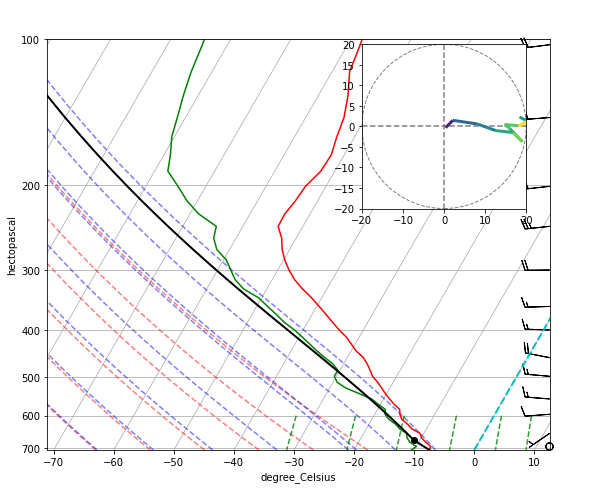

In [222]:
plot_skewT(mean_ds)

In [220]:
mean_ds.rh

<xarray.DataArray 'rh' (pres_bins: 50)>
array([79.23047  , 82.886925 , 81.23216  , 82.465805 , 83.586044 ,
       84.66988  , 84.96034  , 83.573875 , 81.295975 , 81.796196 ,
       79.64032  , 77.24171  , 67.9717   , 58.38371  , 54.171265 ,
       55.69543  , 60.92631  , 58.677692 , 54.479103 , 53.238243 ,
       50.71887  , 48.14477  , 46.87764  , 43.355587 , 41.66569  ,
       39.558304 , 37.84943  , 32.826073 , 31.608326 , 31.684187 ,
       30.947716 , 26.150135 , 24.216837 , 27.124548 , 15.60288  ,
        9.179855 ,  5.8310184,  3.1500752,  2.5769691,  2.226119 ,
        2.0715206,  2.0528414,  2.232253 ,  2.186234 ,  2.096495 ,
        2.2386205,  1.8483292,  1.5456318,  1.2415531,  1.004884 ],
      dtype=float32)
Coordinates:
  * pres_bins  (pres_bins) object (702.003, 716.1] ... (10.525, 25.327]

In [ ]:
def plot_sonde(date,variable, limits, title):
    # Apply date filter
    sonde_temp_profile = sonde_ds.sel(time=slice(f'{date} 09',f'{date} 15')).resample(time='min').mean()
        
    # Plot data
    fig, axs = plt.subplots(ncols=2, figsize=(10,5), tight_layout=True)
    axs[0].plot(sonde_temp_profile[variable],sonde_temp_profile['alt'])
    axs[0].set_xlim(limits[0],limits[1])
    axs[0].set_ylim(3000,10000)
    axs[0].set_xlabel('Relative Humidity (%)');
    axs[0].set_ylabel('Altitude (m)');
    axs[0].set_title(f'{variable.upper()} with Altitude');

    axs[1].plot(sonde_temp_profile[variable],sonde_temp_profile['pres'])
    axs[1].set_xlim(limits[0],limits[1])
    axs[1].set_ylim(725,350)
    axs[1].set_xlabel('Relative Humidity (%)');
    axs[1].set_ylabel('Pressure (mbar)');
    axs[1].set_title(f'{variable.upper()} with Pressure');

    fig.suptitle(f'{title} on {date}')
    return

In [ ]:
sonde_ds_abl = sonde_ds.where(sonde_ds.alt<4000)

In [ ]:
from datetime import datetime
import warnings
dates = np.unique(pd.to_datetime(sonde_ds_abl.time).date)
make_df=False

In [ ]:
if make_df is True:
    abl_heights = []
    inversion_bool = []

    warnings.filterwarnings("ignore", category=RuntimeWarning)

    for i,date in enumerate(dates):
        
        # set start and end dates with times
        start = date.strftime("%Y-%m-%d")+" 06"
        end = date.strftime("%Y-%m-%d")+" 17"
        print(f'Starting {start}')

        # slice for daily radiosonde
        daily_radiosonde = sonde_ds_abl.sel(time=slice(start, end))
        try:
            # separate into 10 meter averages
            alt_groups = daily_radiosonde.groupby(daily_radiosonde.alt // 10).mean()
            # calculate abl height
            abl_height = 10 * (alt_groups.tdry.diff(dim='alt')<0).idxmax().compute().values - daily_radiosonde.alt.min()
            abl_heights.append(abl_height)

            # if abl height is larger than 10 meters, inversion exists
            if abl_height > 10:
                inversion_bool.append(True)
            else: inversion_bool.append(False)
        except:
            pass
else:
    hgts_day_df = pd.read_csv(os.path.join(outpath, 'inversion_heights_day.csv'))

In [ ]:
if make_df is True:
    hgts_day = [abl_heights[i].compute().values for i in range(len(abl_heights))]
    hgts_day_df = pd.DataFrame([hgts_day,inversion_bool]).T
    hgts_day_df = hgts_day_df.rename(columns={0:'heights',1:'inversion_bool'})
    hgts_day_df.to_csv(os.path.join(outpath,'inversion_heights_day.csv'))

Text(0.5, 1.0, 'SAIL Radiosonde Profiles with Near Surface Inversion\nDecember 2021 - March 2022')

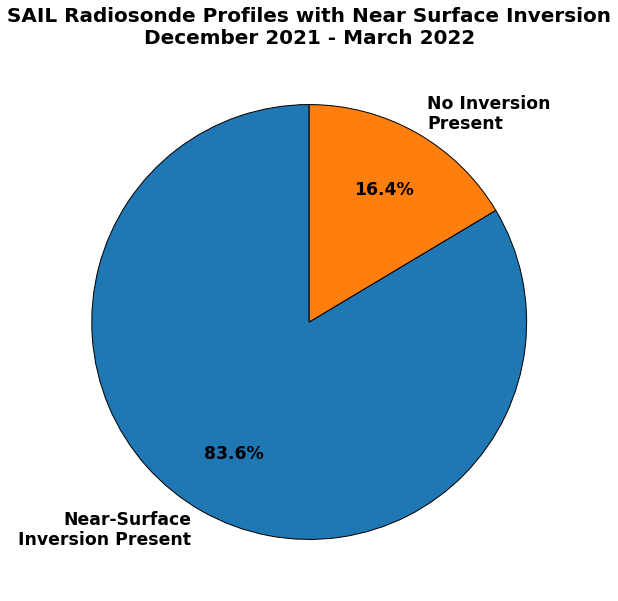

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
fig.set_facecolor('white')

title = 'SAIL Radiosonde Profiles with Near Surface Inversion\nDecember 2021 - March 2022'
labels = ['Near-Surface\nInversion Present','No Inversion\nPresent']

inversion_percent = 100*hgts_day_df[hgts_day_df['inversion_bool']==True]['inversion_bool'].sum()/len(hgts_day_df)


unstable = 100 - inversion_percent
sizes = [inversion_percent, unstable]
pie_plot = ax.pie(sizes,autopct='%1.1f%%', wedgeprops={'linewidth':1, 'edgecolor':'k'},labels=labels, 
                      startangle=90, pctdistance=0.7,radius=1, labeldistance=1.1, textprops={'color':'black','size': 'xx-large','fontweight':'bold'})
ax.set_title(f'{title}', size=20, fontweight='bold')

In [ ]:
len(hgts_day_df['inversion_bool'])

67

In [ ]:
hgts_day_df.loc[5:20]

,Unnamed: 0,heights,inversion_bool
5,5,11.600098,True
6,6,11.600098,True
7,7,11.600098,True
8,8,11.600098,True
9,9,11.600098,True
10,10,71.600100,True
11,11,441.600100,True
12,12,11.600098,True
13,13,11.600098,True
14,14,71.600100,True
